In [25]:
%matplotlib inline

import pandas as pd
import numpy as np
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import os
import os.path

In [26]:
scenarios_folder = os.path.expanduser('~/interscsimulator/scenarios/digital-rails-av-paulista/')
dr_events_filename_template = scenarios_folder + '{}/arrivals{}.xml'

In [27]:
def parse_arrivals(filename, prefix=''):
    tree = ET.parse(filename)
    root = tree.getroot()

    events = []
    for child in root:        
        if (len(prefix) == 0 or (prefix in child.attrib['person'])):
            trip_time = int(child.attrib['trip_time'])
            distance = int(child.attrib['distance'])

            events.append({'trip_time_s': trip_time, 'distance_m': distance})

    return pd.DataFrame(events)

In [28]:
def group_repetitions(scenarios, repetitions, parse_arrivals_prefix=''):
    ratio = 0
    round_stats = []
    
    for s in scenarios:
        for r in repetitions:
            dr = parse_arrivals(dr_events_filename_template.format(s, r), parse_arrivals_prefix)
            dr['avg_speed_km/h'] = 3.6 * dr['distance_m'] / dr['trip_time_s']
            dr = dr.drop(columns='distance_m')

            round_stats.append({
                'round': r, 
                'avg_time_s': dr['trip_time_s'].mean(),
                '50%_time_s': dr['trip_time_s'].median(),
                'avg_speed_km/h': dr['avg_speed_km/h'].mean(), 
                'ratio': ratio
            })

        ratio += 5
   
    return pd.DataFrame(round_stats).set_index(['ratio', 'round'])

# All cars (DR + regular)

In [29]:
benchmarks = [
    'peak_cet_0_0',
]

scenarios = [
    'peak_dr_algo_1_0',
    'peak_dr_algo_1_5',
    'peak_dr_algo_1_10',
    'peak_dr_algo_1_15',
    'peak_dr_algo_1_20',
    'peak_dr_algo_1_25',
    'peak_dr_algo_1_30',
    'peak_dr_algo_1_35',
    'peak_dr_algo_1_40',
    'peak_dr_algo_1_45',
    'peak_dr_algo_1_50',
    'peak_dr_algo_1_55',
    'peak_dr_algo_1_60',
    'peak_dr_algo_1_65',
    'peak_dr_algo_1_70',
    'peak_dr_algo_1_75',
    'peak_dr_algo_1_80',
    'peak_dr_algo_1_85',
    'peak_dr_algo_1_90',
    'peak_dr_algo_1_95',
    'peak_dr_algo_1_100'
]

repetitions = range(10)

df = group_repetitions(scenarios, repetitions, '')
df.head()

50%_time_s  avg_speed_km/h   avg_time_s
ratio round                                         
0     0           784.0       11.540349  1039.443052
      1           796.0       11.725788  1015.172871
      2           809.5       11.468163  1030.721157
      3           786.0       11.335349  1070.054921
      4           810.5       11.529885  1054.611684

In [30]:
bdf = group_repetitions(benchmarks, repetitions, '')
bdf.head()

50%_time_s  avg_speed_km/h  avg_time_s
ratio round                                        
0     0           600.0       16.874682  599.410984
      1           515.0       19.115237  523.133616
      2           510.0       19.281547  518.152967
      3           520.0       19.040006  525.114080
      4           630.0       16.006529  629.015297

## Trip time

In [31]:
grouped_time_df = df.groupby('ratio').agg({'avg_time_s': ['mean', 'std'], '50%_time_s': ['mean', 'std']})
grouped_time_df

avg_time_s            50%_time_s           
              mean        std       mean        std
ratio                                              
0      1038.762366  27.680319     803.00  14.402932
5       815.811359  45.064065     721.10  24.812407
10      722.787544  23.758392     647.30   6.325434
15      654.455338   7.656992     618.25   4.854837
20      591.622121  16.324845     576.15  39.831625
25      506.507606  28.101063     484.00  38.632169
30      443.235113  16.200621     426.30  19.206770
35      379.549390   8.968492     391.85   5.617680
40      338.189200   9.002324     355.20   5.349974
45      301.687925   7.035171     311.80   1.549193
50      275.102226   1.418892     254.60   2.270585
55      258.227884   0.502224     205.00   0.000000
60      243.983897   0.669333     205.00   0.000000
65      233.531796   0.430558     205.00   0.000000
70      225.235530   0.412748     205.00   0.000000
75      218.424022   0.267035     205.00   0.000000
80      212.795910   0.152468     205.00   0.000000
85      207.907888   0.122554     205.00   0.000000
90      203.594909   0.109874     191.00   0.000000
95      200.203506   0.088032     191.00   0.000000
100     197.059701   0.000000     191.00   0.000000

In [32]:
grouped_bench_time_df = bdf.groupby('ratio').agg({'avg_time_s': ['mean', 'std'], '50%_time_s': ['mean', 'std']})
grouped_bench_time_df

avg_time_s            50%_time_s           
             mean        std       mean        std
ratio                                             
0      563.186712  44.849701     561.75  47.458315

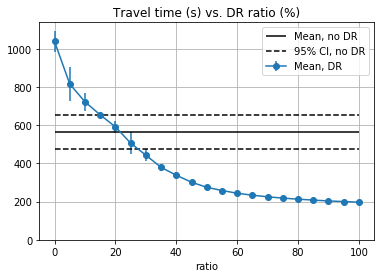

In [33]:
ax = grouped_time_df['avg_time_s']['mean'].plot(
    marker='o', 
    yerr=2*grouped_time_df['avg_time_s']['std'],
    ylim=(0, None),
    title='Travel time (s) vs. DR ratio (%)',
    grid=True,
)

cet_mean = grouped_bench_time_df.loc[0]['avg_time_s']['mean']
cet_std = grouped_bench_time_df.loc[0]['avg_time_s']['std']

ax.hlines(y=cet_mean, xmin=0, xmax=100)
ax.hlines(y=[cet_mean+2*cet_std, cet_mean-2*cet_std], xmin=0, xmax=100, linestyle='--')


ax.legend(['Mean, no DR', '95% CI, no DR', 'Mean, DR'])

In [34]:
# ax = grouped_time_df['50%_time_s']['mean'].plot(
#     marker='o', 
#     yerr=2*grouped_time_df['50%_time_s']['std'],
#     ylim=(0, None),
#     title='Median trip time (s) vs. DR ratio (%)'
# )

# cet_mean = grouped_bench_time_df.loc[0]['50%_time_s']['mean']
# cet_std = grouped_bench_time_df.loc[0]['50%_time_s']['std']

# ax.hlines(y=cet_mean, xmin=0, xmax=100)
# ax.hlines(y=[cet_mean+2*cet_std, cet_mean-2*cet_std], xmin=0, xmax=100, linestyle='--')


# ax.legend(['Median, no DR', '95% CI, no DR', 'Median, DR'])

### Highlights

- As expected, trip times decrease when the ratio of vehicles using DRs increase
- If 25% of vehicles are using DRs, the average trip time is 502s (8m22s), which is 95% of the average 526s (8m46s) using the current traffic light settings.
- If 75% of vehicles are using DRs, the average trip time is 219s (3m39s), which is 41% of the average 526s (8m46s) using the current traffic light settings.
- With 45% of vehicles using DRs, 99% of all trips have time below 515s (8m35s), which is less than of the average 526s (8m46s) using the current traffic light settings.

## Average speed

(Omitted because the results would be the same)

In [35]:
# speed_df.T[['mean', 'std', 'min', '1%', '50%', 'max']]

In [36]:
# speed_df.T[['mean', '1%']].plot(kind='bar', title='Avg speed (km/h) / scenario')

# Cars outside DR

In [37]:
benchmarks = [
    'peak_cet_0_0',
]

scenarios = [
    'peak_dr_algo_1_0',
    'peak_dr_algo_1_5',
    'peak_dr_algo_1_10',
    'peak_dr_algo_1_15',
    'peak_dr_algo_1_20',
    'peak_dr_algo_1_25',
    'peak_dr_algo_1_30',
    'peak_dr_algo_1_35',
    'peak_dr_algo_1_40',
    'peak_dr_algo_1_45',
    'peak_dr_algo_1_50',
    'peak_dr_algo_1_55',
    'peak_dr_algo_1_60',
    'peak_dr_algo_1_65',
    'peak_dr_algo_1_70',
    'peak_dr_algo_1_75',
    'peak_dr_algo_1_80',
    'peak_dr_algo_1_85',
    'peak_dr_algo_1_90',
    'peak_dr_algo_1_95',
]

repetitions = range(10)

df = group_repetitions(scenarios, repetitions, 'regular')
df.head()

50%_time_s  avg_speed_km/h   avg_time_s
ratio round                                         
0     0           784.0       11.540349  1039.443052
      1           796.0       11.725788  1015.172871
      2           809.5       11.468163  1030.721157
      3           786.0       11.335349  1070.054921
      4           810.5       11.529885  1054.611684

In [38]:
bdf = group_repetitions(benchmarks, repetitions, '')
bdf.head()

50%_time_s  avg_speed_km/h  avg_time_s
ratio round                                        
0     0           600.0       16.874682  599.410984
      1           515.0       19.115237  523.133616
      2           510.0       19.281547  518.152967
      3           520.0       19.040006  525.114080
      4           630.0       16.006529  629.015297

## Trip time

In [39]:
grouped_time_df = df.groupby('ratio').agg({'avg_time_s': ['mean', 'std', 'min'], '50%_time_s': ['mean', 'std']})
grouped_time_df

avg_time_s                        50%_time_s           
              mean        std         min       mean        std
ratio                                                          
0      1038.762366  27.680319  999.488021     803.00  14.402932
5       848.106713  47.416070  787.668607     741.65  24.091319
10      780.487344  26.366317  747.873029     679.50  10.024969
15      734.096769   8.990448  715.702451     653.90   6.384878
20      688.164217  20.319542  638.501382     625.50  27.934447
25      609.007545  37.410534  530.696977     562.40  41.139870
30      548.082671  23.099858  511.392415     495.70  24.900022
35      477.145576  13.765592  448.578559     464.05  11.354025
40      431.038495  14.929200  416.157296     435.10  12.556096
45      385.861918  12.695383  370.288300     383.80  14.612019
50      352.223894   2.821043  349.149705     352.30   1.702939
55      332.408357   1.111229  331.242114     330.60   1.264911
60      314.093545   1.669165  312.162748     311.20   1.873796
65      300.302424   1.219990  298.202318     296.55   1.640630
70      290.242041   1.366610  288.786109     287.50   0.849837
75      282.005609   1.063215  280.444280     282.50   0.707107
80      275.377399   0.760088  274.463100     277.40   0.843274
85      269.133333   0.815971  268.370234     271.20   1.475730
90      262.343808   1.100973  261.120148     263.30   1.946507
95      258.581111   1.757375  256.581481     259.45   3.113144

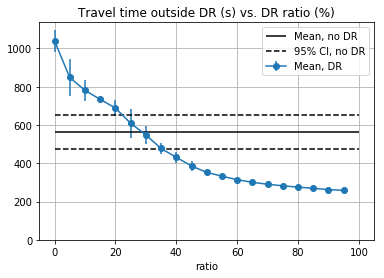

In [40]:
ax = grouped_time_df['avg_time_s']['mean'].plot(
    marker='o', 
    yerr=2*grouped_time_df['avg_time_s']['std'],
    ylim=(0, None),
    title='Travel time outside DR (s) vs. DR ratio (%)',
    grid=True,
)

cet_mean = grouped_bench_time_df.loc[0]['avg_time_s']['mean']
cet_std = grouped_bench_time_df.loc[0]['avg_time_s']['std']

ax.hlines(y=cet_mean, xmin=0, xmax=100)
ax.hlines(y=[cet_mean+2*cet_std, cet_mean-2*cet_std], xmin=0, xmax=100, linestyle='--')

ax.legend(['Mean, no DR', '95% CI, no DR', 'Mean, DR'])

In [41]:
# ax = grouped_time_df['50%_time_s']['mean'].plot(
#     marker='o', 
#     yerr=2*grouped_time_df['50%_time_s']['std'],
#     ylim=(0, None),
#     title='Median trip time outside DR (s) vs. DR ratio (%)'
# )

# cet_mean = grouped_bench_time_df.loc[0]['avg_time_s']['mean']
# cet_std = grouped_bench_time_df.loc[0]['avg_time_s']['std']

# ax.hlines(y=cet_mean, xmin=0, xmax=100)
# ax.hlines(y=[cet_mean+2*cet_std, cet_mean-2*cet_std], xmin=0, xmax=100, linestyle='--')


# ax.legend(['Median, no DR', '95% CI, no DR', 'Median, DR'])

### Highlights
- As expected (considering the velocity model we are using), trip time for vehicles outside DRs also decreases when the ratio of vehicles in DRs increases.
- If 35% of vehicles are using DRs, the average trip time for vehicles outside DRs is 466s (7m46s), which is 89% of the average 526s (8m46s) with current traffic signal settings.
- If 45% of vehicles are using DRs, 99% of the trips outside DRs take less than 522s (8m42s), which is 99% of the average 526s (8m46s) with current traffic signal settings.

## Average speed

(Omitted because the results would be the same)

In [42]:
# speed_df.T[['mean', 'std', 'min', '1%', '50%', 'max']]

In [43]:
#speed_df.T[['mean', '1%']].plot(kind='bar', title='Avg speed outside DR (km/h) / scenario')

### Average time lost in traffic lights

(Justifying the times reported at [this spreadsheet](https://docs.google.com/spreadsheets/d/1Ji3D-NZYW6UwcDKrwaKOn4oEMsGOlNvlfKbELR77cDA/edit?usp=sharing))

#### 35% DR

In [44]:
df = parse_arrivals(dr_events_filename_template.format('peak_dr_algo_1_35', '0'), 'paraiso_regular').iloc[1000:2000]
(df['trip_time_s'].mean() - df['trip_time_s'].min()) / 13

9.747582623755232

In [45]:
(df['distance_m'] / df['trip_time_s']).mean()

7.3906270954782824

#### 45% DR

In [46]:
df = parse_arrivals(dr_events_filename_template.format('peak_dr_algo_1_45', '0'), 'paraiso_regular').iloc[1000:2000]
(df['trip_time_s'].mean() - df['trip_time_s'].min()) / 13

8.79279979279979

In [47]:
(df['distance_m'] / df['trip_time_s']).mean()

7.855391900363431